In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score
import joblib
import os
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cấu hình đường dẫn đầu vào/đầu ra
model_name = "XGBoost"
input_folder = 'folder_standardized'
output_folder = 'models_and_results'
os.makedirs(output_folder, exist_ok=True)

print("--- KHỞI TẠO XGBOOST ---")

--- KHỞI TẠO XGBOOST ---


In [4]:
def load_data():
    """
    Đọc dữ liệu đã xử lý từ folder_standardized (kết quả của preprocessing.ipynb).
    
    Returns:
        tuple: (X_train, y_train, X_test, y_test) - Bộ dữ liệu huấn luyện và kiểm tra
        
    Raises:
        FileNotFoundError: Nếu không tìm thấy dữ liệu đã xử lý
    """
    print("\n1. LOAD DATA")
    try:
        X_train = pd.read_csv(os.path.join(input_folder, 'X_train.csv'))
        y_train = pd.read_csv(os.path.join(input_folder, 'y_train.csv')).values.ravel()
        X_test = pd.read_csv(os.path.join(input_folder, 'X_test.csv'))
        y_test = pd.read_csv(os.path.join(input_folder, 'y_test.csv')).values.ravel()
        
        print(f"   - Đọc dữ liệu thành công")
        print(f"   - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"   - X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
        return X_train, y_train, X_test, y_test
    except FileNotFoundError:
        print("   ✗ Lỗi: Không tìm thấy dữ liệu. Hãy chạy processing.ipynb trước!")
        exit()

X_train, y_train, X_test, y_test = load_data()


1. LOAD DATA
   - Đọc dữ liệu thành công
   - X_train shape: (5616, 34), y_train shape: (5616,)
   - X_test shape: (1405, 34), y_test shape: (1405,)


In [5]:
def train_model():
    """
    Huấn luyện mô hình XGBoost với tối ưu hóa tham số.
    
    Quy trình:
    1. Xây dựng Pipeline gồm SMOTE (cân bằng dữ liệu) + XGBoost
    2. Sử dụng RandomizedSearchCV để tìm tham số tối ưu
    3. Tối ưu hóa theo điểm F1 (cân bằng giữa Precision và Recall)
    4. Tìm ngưỡng phân loại tối ưu để cải thiện hiệu suất
    
    Returns:
        tuple: (best_model, best_threshold, y_prob) - Model, ngưỡng tối ưu, xác suất dự đoán
    """
    print(f"\n2. TRAIN MODEL: {model_name}")
    
    # Pipeline: SMOTE (xử lý class imbalance) -> XGBoost
    # SMOTE sẽ chỉ áp dụng lên tập train của từng fold khi chạy Cross-Validation
    pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', XGBClassifier(
            objective='binary:logistic',    # Mục tiêu: phân loại nhị phân
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42
        ))
    ])
    
    # Lưới tham số cần tối ưu (thêm tiền tố 'model__' vào trước tên tham số XGBoost)
    param_grid = {
        'model__n_estimators': [100, 200, 300],         # Số cây (boosting rounds)
        'model__learning_rate': [0.01, 0.05, 0.1],      # Tốc độ học (eta)
        'model__max_depth': [3, 4, 5, 6],               # Độ sâu cây
        'model__subsample': [0.7, 0.8],                 # Tỉ lệ mẫu cho mỗi cây
        'model__colsample_bytree': [0.7, 0.8],          # Tỉ lệ feature cho mỗi cây
    }
    
    # RandomizedSearchCV: Thử n_iter tổ hợp ngẫu nhiên (nhanh hơn GridSearchCV)
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=10,        # Thử 10 tổ hợp ngẫu nhiên
        scoring='f1',     # Tối ưu hóa theo F1-score
        cv=3,             # 3-fold cross-validation
        verbose=1,
        random_state=42,
        n_jobs=-1         # Sử dụng tất cả CPU cores
    )

    print("   - Đang tìm tham số tối ưu (RandomizedSearchCV)...")
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    print(f"   - Tham số tốt nhất: {search.best_params_}")
    
    # Tìm ngưỡng phân loại tối ưu
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import precision_recall_curve
    
    print("   - Đang tìm ngưỡng tối ưu dựa trên Cross-Validation của tập Train...")
    # Lấy xác suất của lớp 1 (Churn) trên tập train
    y_train_prob_cv = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    
    # Tính toán precision, recall dựa trên y_train và xác suất vừa tạo
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_prob_cv)
    
    # Tính F1 score cho mọi ngưỡng
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Lấy ngưỡng có F1 cao nhất (Lưu ý: bỏ qua giá trị nan nếu có)
    f1_scores = np.nan_to_num(f1_scores) 
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    print(f"   - Ngưỡng phân loại tối ưu (tìm trên Train): {best_threshold:.4f}")
    
    # 3. Tạo y_prob cho tập Test để trả về (Dùng cho bước Evaluate sau này)
    y_prob_test = best_model.predict_proba(X_test)[:, 1]

    return best_model, best_threshold, y_prob_test

best_model, best_threshold, y_prob = train_model()


2. TRAIN MODEL: XGBoost
   - Đang tìm tham số tối ưu (RandomizedSearchCV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
   - Tham số tốt nhất: {'model__subsample': 0.7, 'model__n_estimators': 300, 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.8}
   - Đang tìm ngưỡng tối ưu dựa trên Cross-Validation của tập Train...
   - Ngưỡng phân loại tối ưu (tìm trên Train): 0.5294


In [6]:
def evaluate_model(best_threshold, y_prob):
    """
    Đánh giá hiệu suất mô hình trên tập Test với ngưỡng tối ưu.
    
    Quy trình:
    1. Áp dụng ngưỡng phân loại tối ưu để tạo dự đoán nhị phân
    2. Tính toán Accuracy và các chỉ số khác (Precision, Recall, F1)
    3. Hiển thị báo cáo phân loại chi tiết
    
    Args:
        best_threshold (float): Ngưỡng phân loại tối ưu (0-1)
        y_prob (ndarray): Xác suất dự đoán class=1 từ mô hình
    
    Returns:
        tuple: (y_pred, accuracy) - Dự đoán nhị phân và độ chính xác
    """
    print("\n3. EVALUATE MODEL")
    
    # Áp dụng ngưỡng phân loại tối ưu
    y_pred = (y_prob >= best_threshold).astype(int)
    
    # Tính accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Hiển thị báo cáo phân loại chi tiết
    print(f"   - Dự đoán với ngưỡng {best_threshold:.4f}")
    print(f"   - Độ chính xác (Accuracy): {accuracy:.4f}")
    print("\n" + classification_report(y_test, y_pred, 
                                      target_names=['No Churn', 'Yes Churn']))
    
    return y_pred, accuracy

y_pred, accuracy = evaluate_model(best_threshold, y_prob)


3. EVALUATE MODEL
   - Dự đoán với ngưỡng 0.5294
   - Độ chính xác (Accuracy): 0.7609

              precision    recall  f1-score   support

    No Churn       0.90      0.76      0.83      1053
   Yes Churn       0.52      0.75      0.61       352

    accuracy                           0.76      1405
   macro avg       0.71      0.76      0.72      1405
weighted avg       0.80      0.76      0.77      1405




ĐÁNH GIÁ CHI TIẾT MÔ HÌNH: XGBoost

Chỉ số          Train        Test         Chênh lệch     
------------------------------------------------------------
Accuracy        0.7877       0.7609       0.0269         
Precision       0.5785       0.5156       0.0629         
Recall          0.7661       0.7500       0.0161         
F1-Score        0.6592       0.6111       0.0481         
ROC-AUC         0.8651       0.8458       0.0193         

PHÂN TÍCH MÔ HÌNH:
✓ Mô hình có độ tổng quát hóa TỐT
  → Chênh lệch giữa Train và Test nhỏ (<5%)


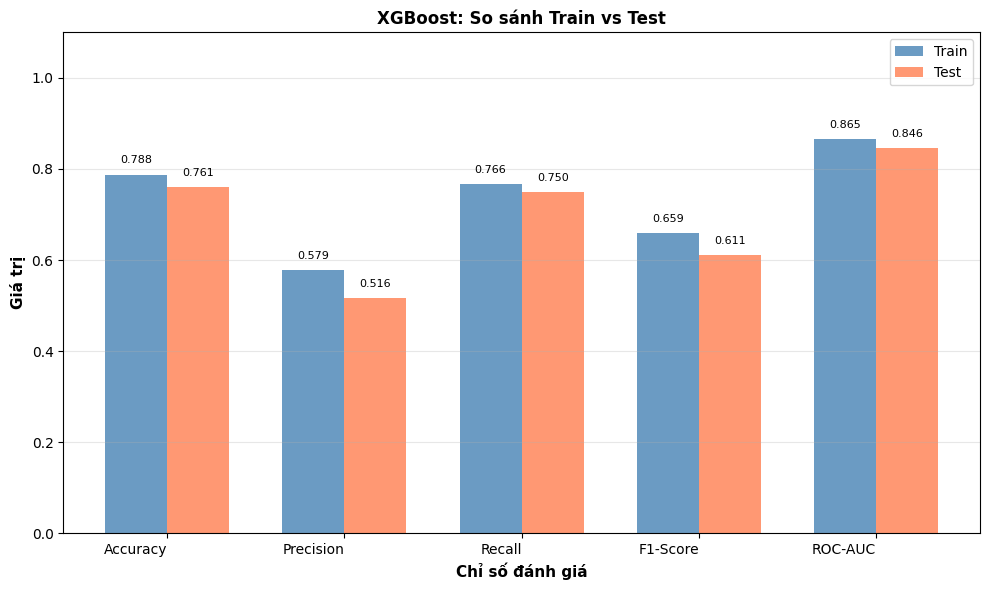


✓ Đã lưu biểu đồ đánh giá tại: models_and_results\XGBoost_comprehensive_evaluation.png



In [7]:
def comprehensive_model_evaluation(best_model, best_threshold, X_train, y_train, X_test, y_test, model_name):
    """
    Đánh giá toàn diện mô hình trên cả tập Train và Test, so sánh hiệu suất.
    
    Args:
        best_model: Mô hình đã được huấn luyện
        best_threshold: Ngưỡng phân loại tối ưu
        X_train, y_train: Dữ liệu training
        X_test, y_test: Dữ liệu testing
        model_name: Tên mô hình
    """
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print(f"\n{'='*60}")
    print(f"ĐÁNH GIÁ CHI TIẾT MÔ HÌNH: {model_name}")
    print(f"{'='*60}\n")
    
    # Dự đoán cho cả 2 tập
    y_train_prob = best_model.predict_proba(X_train)[:, 1]
    y_train_pred = (y_train_prob >= best_threshold).astype(int)
    
    y_test_prob = best_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_prob >= best_threshold).astype(int)
    
    # Tính các chỉ số cho Train
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1-Score': f1_score(y_train, y_train_pred),
        'ROC-AUC': roc_auc_score(y_train, y_train_prob)
    }
    
    # Tính các chỉ số cho Test
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_prob)
    }
    
    # In bảng so sánh
    print(f"{'Chỉ số':<15} {'Train':<12} {'Test':<12} {'Chênh lệch':<15}")
    print("-" * 60)
    for metric in train_metrics.keys():
        train_val = train_metrics[metric]
        test_val = test_metrics[metric]
        diff = train_val - test_val
        print(f"{metric:<15} {train_val:<12.4f} {test_val:<12.4f} {diff:<15.4f}")
    
    # Phân tích Overfitting/Underfitting
    print(f"\n{'='*60}")
    print("PHÂN TÍCH MÔ HÌNH:")
    print(f"{'='*60}")
    
    avg_diff = np.mean([abs(train_metrics[m] - test_metrics[m]) for m in train_metrics.keys()])
    
    if avg_diff < 0.05:
        print("✓ Mô hình có độ tổng quát hóa TỐT")
        print("  → Chênh lệch giữa Train và Test nhỏ (<5%)")
    elif avg_diff < 0.10:
        print("⚠ Mô hình có độ tổng quát hóa KHẤP")
        print("  → Chênh lệch giữa Train và Test ở mức trung bình (5-10%)")
    else:
        print("✗ Mô hình có dấu hiệu OVERFITTING")
        print("  → Chênh lệch giữa Train và Test lớn (>10%)")
        print("  → Xem xét: giảm độ phức tạp mô hình, tăng regularization, hoặc thu thập thêm dữ liệu")
    
    if test_metrics['Accuracy'] < 0.70:
        print("\n⚠ Độ chính xác trên Test thấp (<70%)")
        print("  → Xem xét: thử mô hình khác, feature engineering, hoặc thu thập thêm dữ liệu")
    
    # Visualization: So sánh Train vs Test
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Biểu đồ cột so sánh các chỉ số
    metrics_names = list(train_metrics.keys())
    train_values = [train_metrics[m] for m in metrics_names]
    test_values = [test_metrics[m] for m in metrics_names]
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    ax.bar(x - width/2, train_values, width, label='Train', color='steelblue', alpha=0.8)
    ax.bar(x + width/2, test_values, width, label='Test', color='coral', alpha=0.8)
    ax.set_xlabel('Chỉ số đánh giá', fontsize=11, fontweight='bold')
    ax.set_ylabel('Giá trị', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}: So sánh Train vs Test', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names, rotation=0, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])
    
    # Thêm giá trị lên đầu cột
    for i, (t, te) in enumerate(zip(train_values, test_values)):
        ax.text(i - width/2, t + 0.02, f'{t:.3f}', ha='center', va='bottom', fontsize=8)
        ax.text(i + width/2, te + 0.02, f'{te:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    # Lưu biểu đồ
    img_path = os.path.join(output_folder, f'{model_name}_comprehensive_evaluation.png')
    plt.savefig(img_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"\n✓ Đã lưu biểu đồ đánh giá tại: {img_path}")
    print(f"{'='*60}\n")
    
    return train_metrics, test_metrics

# Gọi hàm đánh giá (thêm vào cuối mỗi notebook sau khi train xong)
train_metrics, test_metrics = comprehensive_model_evaluation(
    best_model, 
    best_threshold, 
    X_train, 
    y_train, 
    X_test, 
    y_test, 
    model_name
)


4. VISUALIZE CONFUSION MATRIX


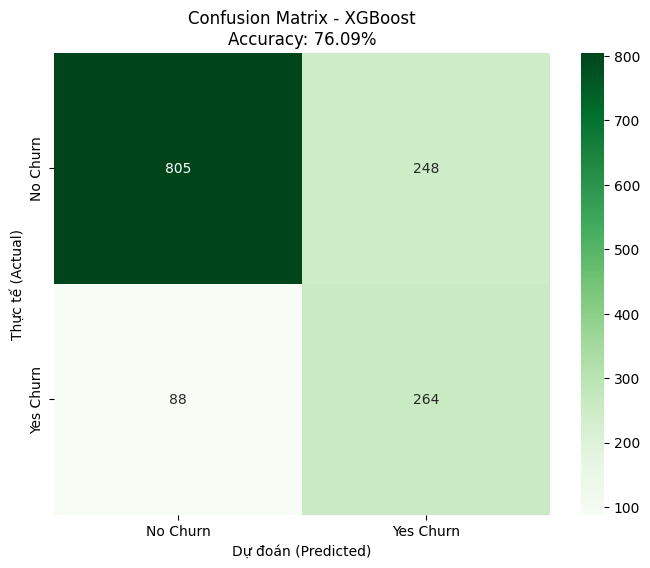

   - Lưu biểu đồ Confusion Matrix tại: models_and_results\XGBoost_confusion_matrix.png


In [8]:
def visualize_confusion_matrix(y_pred, accuracy):
    """
    Vẽ và lưu ma trận nhầm lẫn (Confusion Matrix) dưới dạng heatmap.
    
    Args:
        y_pred (ndarray): Dự đoán nhị phân (0 hoặc 1)
        accuracy (float): Độ chính xác của mô hình
    """
    print("\n4. VISUALIZE CONFUSION MATRIX")
    
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)
    
    # Vẽ heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=['No Churn', 'Yes Churn'], 
                yticklabels=['No Churn', 'Yes Churn'])
    plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.2%}')
    plt.ylabel('Thực tế (Actual)')
    plt.xlabel('Dự đoán (Predicted)')
    
    # Lưu biểu đồ
    img_path = os.path.join(output_folder, f'{model_name}_confusion_matrix.png')
    plt.savefig(img_path, dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"   - Lưu biểu đồ Confusion Matrix tại: {img_path}")

visualize_confusion_matrix(y_pred, accuracy)

In [9]:
def save_model(best_model):
    """
    Lưu mô hình đã huấn luyện để sử dụng trong bước Prediction sau này.
    
    Args:
        best_model (Pipeline): Mô hình đã huấn luyện (Pipeline với SMOTE + XGBoost)
    """
    print("\n5. SAVE MODEL")
    
    # Lưu mô hình dưới dạng pickle file
    model_path = os.path.join(output_folder, f'{model_name}.pkl')
    joblib.dump(best_model, model_path)
    
    print(f"   - Lưu mô hình tại: {model_path}")
    print(f"   → Sẽ dùng cho predict.ipynb")
    print("\n--- HOÀN THÀNH ---")

save_model(best_model)


5. SAVE MODEL
   - Lưu mô hình tại: models_and_results\XGBoost.pkl
   → Sẽ dùng cho predict.ipynb

--- HOÀN THÀNH ---
